# MSE Tracking
This looks at tracking the moist static energy throughout the year, to see when and why the surface value exceeds the free troposphere saturated.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp, moist_profile
from isca_tools.convection.simple_betts_miller import get_temp_ref
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-16 16:57:54,680 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'ucomp', 'klzbs', 't_ref', 'dt_tg_diffusion', 'omega', 'cape', 'tdt_rad', 'vcomp', 
            'flux_lhe', 'flux_t', 't_surf', 'convflag', 'dt_tg_convection', 'dt_tg_condensation'] 
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = ['aquaplanet/temp_tendency/', 'aquaplanet/temp_tendency_no_wishe/']
exp_dir = ['aquaplanet/temp_tendency/']
exp_names = ['WISHE', 'no-WISHE']
kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_dir)
n_kappa = len(kappa_names)
ds = [[] for i in range(n_exp)]
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir[i] + kappa_names[j])[var_keep]
        ds[i] += [ds_use]
        namelist = isca_tools.load_namelist(exp_dir[i] + kappa_names[j])  # Need this for albedo_value
        if i == 0:
            albedo += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk'][::-1])         # make first value the surface
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
sigma_levels = np.convolve(sigma_levels, np.ones(2)/2, 'valid')

## Get datasets
Get one surface dataset for summer for each $\kappa$

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [30]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
use_time_start = 360*2      

lat_use = 18
ds_all = [[] for i in range(n_exp)]
with tqdm(total=n_exp*n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            # Consider a single latitude, and take the zonal mean
            ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf)).sel(lat=lat_use, method='nearest').mean(dim='lon')
            ds_use = annual_mean(ds_use.load())        # take annual mean so only have 360 time indices
            ds_all[i] += [ds_use]
            pbar.update(1)
p_surface = float(ds_all[0][0].pfull[0]) * 100
lat_use_actual = float(ds_all[0][0].lat)

100%|██████████| 2/2 [00:49<00:00, 24.65s/it]


In [31]:
n_pressure = len(ds_all[0][0].pfull)
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(n_pressure), ds_all[0][0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    k = np.clip(k, 1, np.inf)
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

In [32]:
time_array = ds_all[0][0].time-0.5
n_time = len(time_array)

mse_surf = np.zeros((n_exp, n_kappa, n_time))
mse_ft_sat = np.zeros((n_exp, n_kappa, n_time, n_pressure))
mse_ft_sat_ref = np.zeros((n_exp, n_kappa, n_time, n_pressure))
for i in range(n_exp):
    for j in range(n_kappa):
        ds_use = ds_all[i][j].sel(pfull=np.inf, method='nearest')
        mse_surf[i, j] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
        mse_ft_sat[i, j] = moist_static_energy(ds_all[i][j].temp, sphum_sat(ds_all[i][j].temp, ds_all[i][j].pfull*100), ds_all[i][j].height)
        mse_ft_sat_ref[i, j] = moist_static_energy(ds_all[i][j].t_ref, sphum_sat(ds_all[i][j].t_ref, ds_all[i][j].pfull*100), 
                                                   ds_all[i][j].height)

mse_diff = np.expand_dims(mse_surf, axis=-1) - mse_ft_sat  
mse_diff_ref = np.expand_dims(mse_surf, axis=-1) - mse_ft_sat_ref 

In [33]:
# Get LZB, need to ignore times when klzbs=0 as it skews results
lzb_array = np.zeros((n_exp, n_kappa, n_time))
for i in range(n_exp):
    for j in range(n_kappa):
        ds_use = ds[i][j].klzbs.sel(lat=lat_use_actual).load()
        ds_use.values[np.where(ds_use.to_numpy()==0)] = n_pressure      # when index is zero, it means no convection so set LNB to surface value
        lzb_array[i, j] = lzb(annual_mean(ds_use.where(ds_use>0).mean(dim='lon')))

### CAPE throughout the year
This plot tracks how CAPE varies throughout the year. CAPE is large whenever the surface MSE exceeds the saturated MSE below the LNB (solid black line).

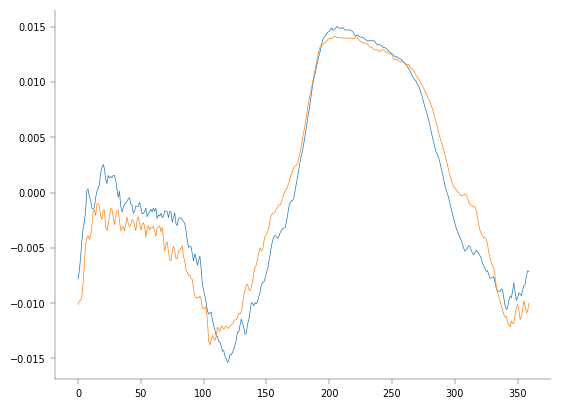

In [34]:
plt.plot((ds_all[0][0].temp[:, 12]-np.mean(ds_all[0][0].temp[:, 12]))/np.mean(ds_all[0][0].temp[:, 12]))
plt.plot((ds_all[0][1].temp[:, 12]-np.mean(ds_all[0][1].temp[:, 12]))/np.mean(ds_all[0][1].temp[:, 12]))

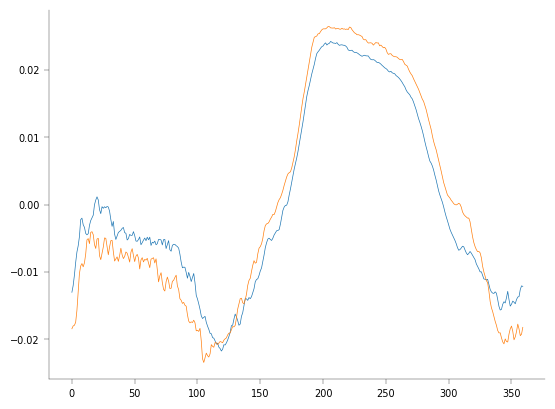

In [35]:
plt.plot((mse_ft_sat[0, 0, :, 12]-np.mean(mse_ft_sat[0, 0, :, 12]))/np.mean(mse_ft_sat[0, 0, :, 12]))
plt.plot((mse_ft_sat[0, 1, :, 12]-np.mean(mse_ft_sat[0, 1, :, 12]))/np.mean(mse_ft_sat[0, 1, :, 12]))

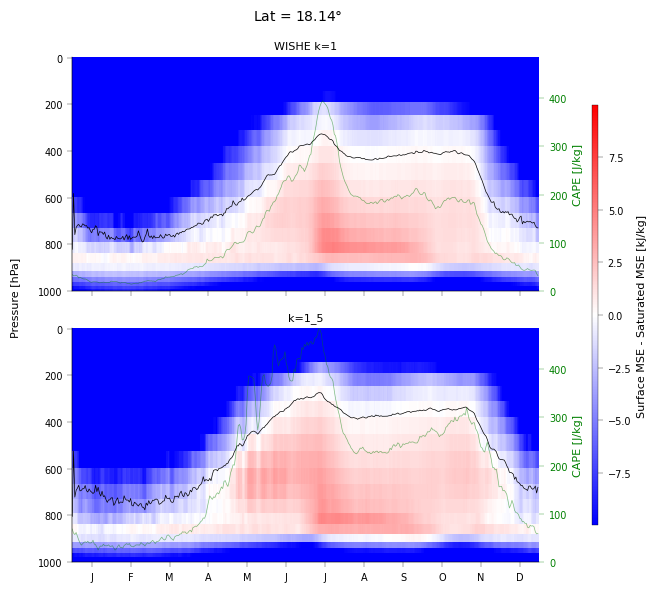

In [36]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
clim = mse_diff.max() * 2

fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, mse_diff[i, j].transpose(), vmin=-clim, vmax=clim, cmap='bwr')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
        ax2 = ax[j, i].twinx()
        ax2.plot(time_array, ds_all[i][j].cape, color='green', alpha=0.5)
        ax2.set_ylim(0, ds_all[0][-1].cape.max())
        ax2.tick_params(colors='green', which='both')
        ax2.set_ylabel('CAPE [J/kg]', color='green')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='Surface MSE - Saturated MSE [kJ/kg]', aspect=100, pad=0.01, fraction=0.01);

### CAPE changes
This looks at how CAPE changes throughout the year i.e. at what times does it increase the most.

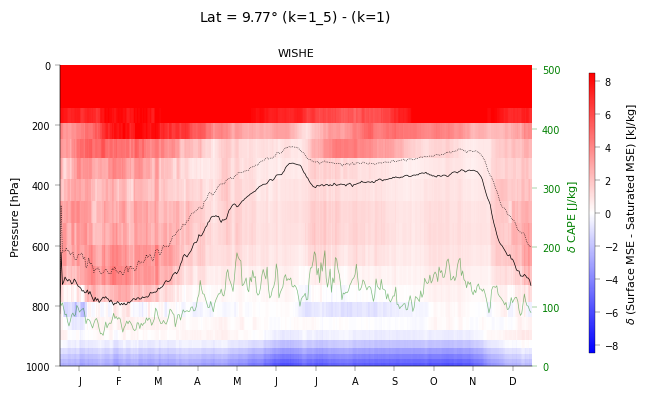

In [250]:
fig, ax = plt.subplots(1, n_exp, figsize=(6*n_exp, 4), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(time_array, ds_all[0][0].pfull, (mse_diff[i, 1]-mse_diff[i, 0]).transpose(), vmin=-clim, vmax=clim, cmap='bwr')
    ax[i].set_title(exp_names[i])
    ax[i].plot(time_array, lzb_array[i, 0], color='k')
    ax[i].plot(time_array, lzb_array[i, 1], color='k', linestyle=':')
    ax2 = ax[i].twinx()
    ax2.plot(time_array, ds_all[i][1].cape-ds_all[i][0].cape, color='green', alpha=0.5)
    ax2.tick_params(colors='green', which='both')
    ax2.set_ylabel('$\delta$ CAPE [J/kg]', color='green')
    ax2.set_ylim(0, ds_all[0][-1].cape.max())
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$ ({kappa_names[1]}) - ({kappa_names[0]})", fontsize=10)
ax[0].invert_yaxis()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$\delta$ (Surface MSE - Saturated MSE) [kJ/kg]', aspect=100, pad=0.01, fraction=0.01);

### Convective reference Temperature
This plot looks at how the actual temperature profile differs from the reference profile that convection in Isca relaxes towards.

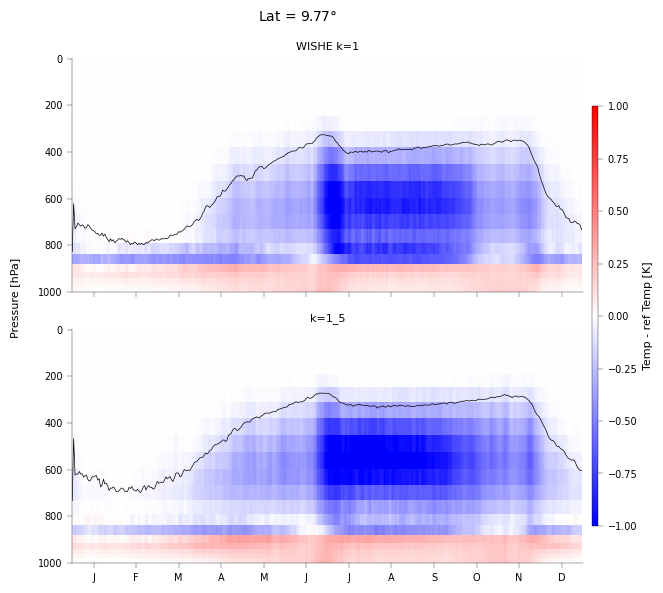

In [251]:
fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, (ds_all[i][j].temp - ds_all[i][j].t_ref).transpose(), 
                                 vmin=-1, vmax=1, cmap='bwr')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='Temp - ref Temp [K]', aspect=100, pad=0.01, fraction=0.01);

### Convective reference CAPE
This plot looks at the CAPE which would be present if the temperature followed the convective reference profile. This reference CAPE is large wherever this figure is red beneath the LNB.

A large reference CAPE means the convective reference profile is a lower temperature than the moist adiabat. If it followed the moist adiabat, the reference CAPE would be zero.

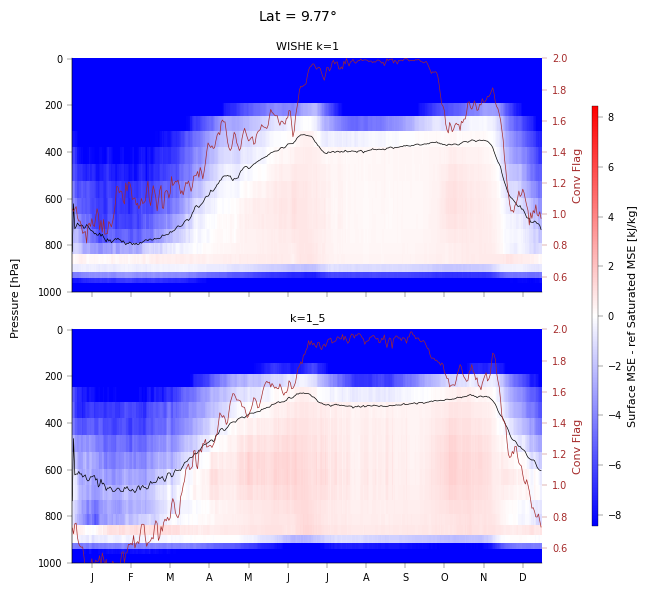

In [252]:
fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, mse_diff_ref[i, j].transpose(), vmin=-clim, vmax=clim, cmap='bwr')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
        ax2 = ax[j, i].twinx()
        ax2.plot(time_array, ds_all[i][j].convflag, color='brown', alpha=1)
        ax2.set_ylim(0.5, 2)
        ax2.tick_params(colors='brown', which='both')
        ax2.set_ylabel('Conv Flag', color='brown')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='Surface MSE - ref Saturated MSE [kJ/kg]', aspect=100, pad=0.01, fraction=0.01);

### Change in convective reference CAPE
This plot looks at the changes in this convective reference CAPE with warming. Red here indicates that the reference profile is becoming even more different to the moist adiabat with warming.

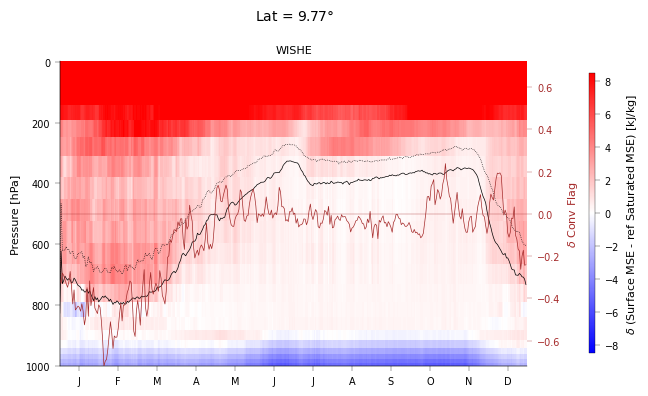

In [253]:
fig, ax = plt.subplots(1, n_exp, figsize=(6 * n_exp, 4), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(time_array, ds_all[0][0].pfull, (mse_diff_ref[i, 1]-mse_diff_ref[i, 0]).transpose(), 
                          vmin=-clim, vmax=clim, cmap='bwr')
    ax[i].set_title(exp_names[i])
    ax[i].plot(time_array, lzb_array[i, 0], color='k')
    ax[i].plot(time_array, lzb_array[i, 1], color='k', linestyle=':')
    ax2 = ax[i].twinx()
    ax2.plot(time_array, ds_all[i][1].convflag - ds_all[i][0].convflag, color='brown', alpha=1)
    ax2.set_ylim(-np.abs(ds_all[i][1].convflag - ds_all[i][0].convflag).max(), np.abs(ds_all[i][1].convflag - ds_all[i][0].convflag).max())
    ax2.tick_params(colors='brown', which='both')
    ax2.set_ylabel('$\delta$ Conv Flag', color='brown')
    ax2.hlines(0, -1, n_time, color='brown', lw=ax_linewidth)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0].invert_yaxis()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$\delta$ (Surface MSE - ref Saturated MSE) [kJ/kg]', aspect=100, pad=0.01, fraction=0.01);

### Vertical wind, $\omega$
This plot is to try and relate changes in CAPE with warming to times when ascent occurs.

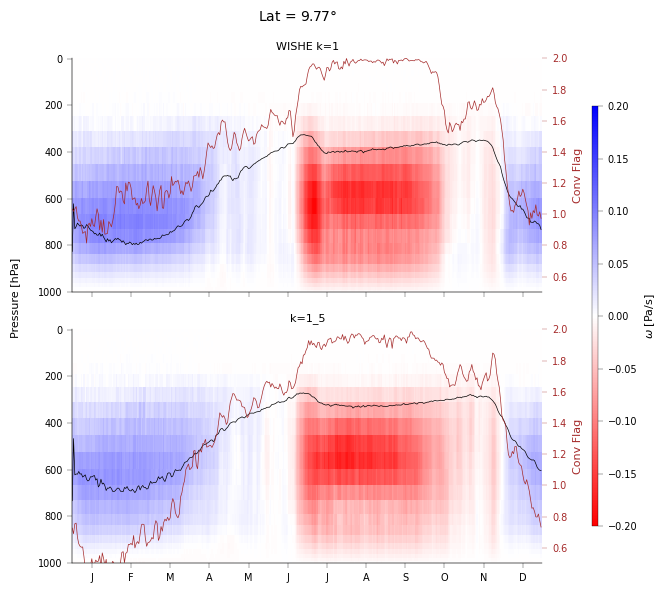

In [254]:
fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, (ds_all[i][j].omega).transpose(), 
                                 vmin=-0.2, vmax=0.2, cmap='bwr_r')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
        ax2 = ax[j, i].twinx()
        ax2.plot(time_array, ds_all[i][j].convflag, color='brown', alpha=1)
        ax2.set_ylim(0.5, 2)
        ax2.tick_params(colors='brown', which='both')
        ax2.set_ylabel('Conv Flag', color='brown')
        # ax2 = ax[j, i].twinx()
        # ax2.plot(time_array, ds_all[i][j].cape, color='green', alpha=0.5)
        # ax2.set_ylim(0, ds_all[0][-1].cape.max())
        # ax2.tick_params(colors='green', which='both')
        # ax2.set_ylabel('CAPE [J/kg]', color='green')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$\omega$ [Pa/s]', aspect=100, pad=0.01, fraction=0.01);

### Meridional wind, $v$
This plot is to try and relate changes in CAPE with warming to times when the direction of $v$ changes.

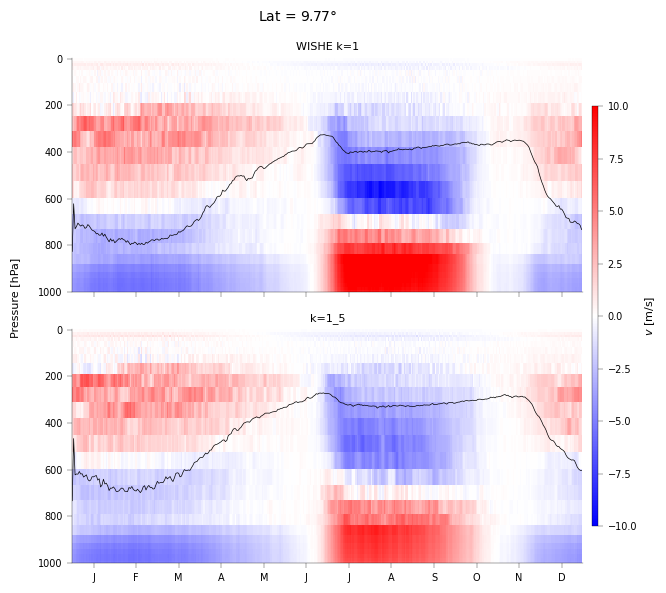

In [255]:
fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, ds_all[i][j].vcomp.transpose(), 
                                 vmin=-10, vmax=10, cmap='bwr')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$v$ [m/s]', aspect=100, pad=0.01, fraction=0.01);

### Zonal wind, $u$
This plot is to try and relate changes in CAPE with warming to times when the direction of $u$ changes.

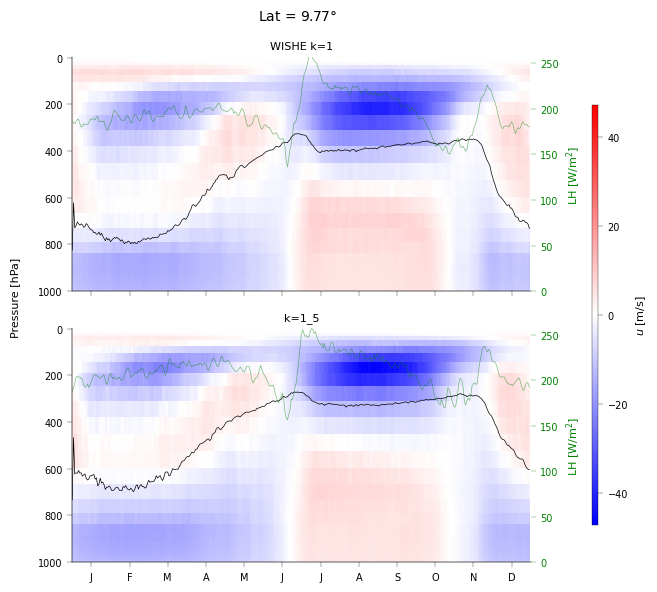

In [256]:
fig, ax = plt.subplots(n_kappa, n_exp, figsize=(6*n_exp, 6), sharex=True, sharey=True)
ax = ax.reshape((n_kappa, n_exp))
for i in range(n_exp):
    for j in range(n_kappa):
        im = ax[j, i].pcolormesh(time_array, ds_all[0][0].pfull, ds_all[i][j].ucomp.transpose(), 
                                 vmin=-np.abs(ds_all[0][1].ucomp).max(), vmax=np.abs(ds_all[0][1].ucomp).max(), cmap='bwr')
        ax[j, i].set_title(exp_names[i] + ' ' + kappa_names[j] if j==0 else kappa_names[j])
        ax[j, i].plot(time_array, lzb_array[i, j], color='k')
        ax2 = ax[j, i].twinx()
        ax2.plot(time_array, ds_all[i][j].flux_lhe, color='green', alpha=0.5)
        ax2.set_ylim(0, ds_all[0][-1].flux_lhe.max())
        ax2.tick_params(colors='green', which='both')
        ax2.set_ylabel('LH [W/m$^2$]', color='green')
        # rh = ds_all[i][j].t_surf - ds_all[i][j].temp[:, -1]
        # ax2.plot(time_array, rh, color='green', alpha=0.5)
        # ax2.set_ylim(0, 10)
        # ax2.tick_params(colors='green', which='both')
        # ax2.set_ylabel('LH [W/m$^2$]', color='green')
fig.supylabel('Pressure [hPa]', fontsize=8)
fig.suptitle(f"Lat = {round(lat_use_actual, 2)}$\degree$", fontsize=10)
ax[0, 0].invert_yaxis()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(0, n_time)
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$u$ [m/s]', aspect=100, pad=0.01, fraction=0.01);

## Temperature Profile of individual days
This is so we can compare the temperature profile on days experiencing shallow and deep convection. With shallow convection, the difference between the moist adiabat and the reference temperature is much larger.

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:152: UserWarning: Changing temp_start to a float
  warnings.warn('Changing temp_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:155: UserWarning: Changing p_start to a float
  warnings.warn('Changing p_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:158: UserWarning: Changing sphum_start to a float
  warnings.warn('Changing sphum_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:164: UserWarning: Changing p_full to a numpy array
  warnings.warn('Changing p_full to a numpy array')


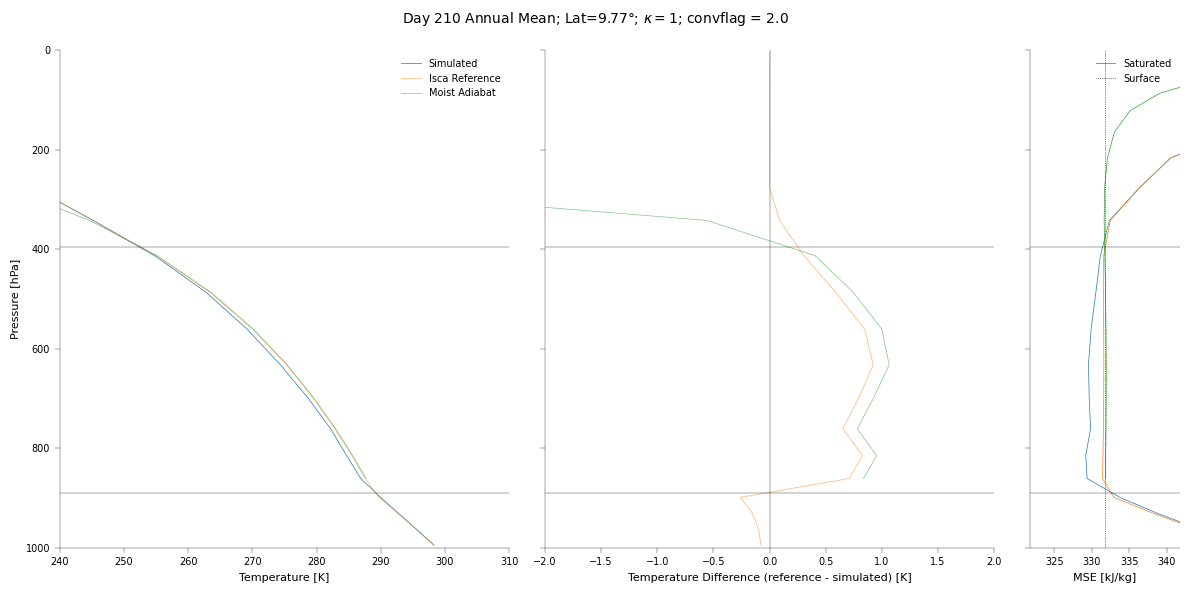

In [262]:
time_ind_use = 160
# time_ind_use = 210
lw_ind_use = 0
include_manual_ref = False
ds_use = ds_all[0][lw_ind_use].isel(time=time_ind_use)
temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], ds_use.pfull[-1]*100, ds_use.sphum[-1], ds_use.pfull*100)
temp_moist_use = moist_profile(float(temp_lcl_use), float(p_lcl_use), ds_use.pfull[ds_use.pfull*100<p_lcl_use]*100)
fig, ax = plt.subplots(1, 3, figsize=(12,6), gridspec_kw={'width_ratios': [3, 3, 1]}, sharey=True)
ax[0].plot(ds_use.temp, ds_use.pfull, color=default_colors[0], label='Simulated')
ax[0].plot(ds_use.t_ref, ds_use.pfull, color=default_colors[1], alpha=0.6, label='Isca Reference')
if include_manual_ref:
    ax[0].plot(temp_ref_manual_use, ds_use.pfull, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[0].plot(temp_moist_use, ds_use.pfull[ds_use.pfull*100<p_lcl_use], color=default_colors[2], alpha=0.6, label='Moist Adiabat')
# ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50, label='LCL')
ax[0].hlines([p_lcl_use/100, lzb(ds_use.klzbs)], 210, 310, color='k', lw=ax_linewidth)
ax[0].set_xlim(240, 310)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(ds_use.t_ref - ds_use.temp, ds_use.pfull, color=default_colors[1], alpha=0.6, label='Isca Reference')
if include_manual_ref:
    ax[1].plot(temp_ref_manual_use - ds_use.temp, ds_use.pfull, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[1].plot(temp_moist_use - ds_use.temp[ds_use.pfull*100<p_lcl_use], ds_use.pfull[ds_use.pfull*100<p_lcl_use], 
           color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].hlines([p_lcl_use/100, lzb(ds_use.klzbs)], -4, 4, color='k', lw=ax_linewidth)
ax[1].set_xlim(-2,2)
ax[1].set_xlabel('Temperature Difference (reference - simulated) [K]')


ax[2].plot(moist_static_energy(ds_use.temp, sphum_sat(ds_use.temp, ds_use.pfull*100), ds_use.height), ds_use.pfull, color=default_colors[0],
           label='Saturated')
ax[2].plot(moist_static_energy(ds_use.t_ref, sphum_sat(ds_use.t_ref, ds_use.pfull*100), ds_use.height), ds_use.pfull, color=default_colors[1])
if include_manual_ref:
    ax[2].plot(moist_static_energy(temp_ref_manual_use, sphum_sat(temp_ref_manual_use, ds_use.pfull*100), ds_use.height),
               ds_use.pfull, color=default_colors[1], linestyle=':')
ax[2].plot(moist_static_energy(temp_moist_use, sphum_sat(temp_moist_use, ds_use.pfull[ds_use.pfull*100<p_lcl_use]*100), 
                               ds_use.height[ds_use.pfull*100<p_lcl_use]), ds_use.pfull[ds_use.pfull*100<p_lcl_use], color=default_colors[2])
ax[2].vlines(moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1]), 1000, 0, color='k', linestyle=':',
             label='Surface')
ax[2].hlines([p_lcl_use/100, lzb(ds_use.klzbs)], 300, 400, color='k', lw=ax_linewidth)
ax[2].set_xlim(moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1])-10, 
               moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1])+10)
ax[2].set_xlabel('MSE [kJ/kg]')
ax[2].legend()


ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'Day {time_ind_use} Annual Mean; Lat={round(lat_use_actual, 2)}$\degree$; $\kappa={tau_lw[lw_ind_use]}$; convflag = {round(float(ds_use.convflag), 2)}', fontsize=10)
plt.tight_layout()

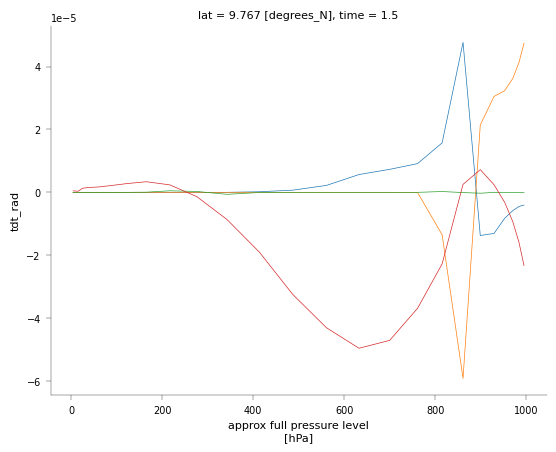

In [383]:
ds_all[0][0].isel(time=1).dt_tg_convection.plot()
ds_all[0][0].isel(time=1).dt_tg_diffusion.plot()
ds_all[0][0].isel(time=1).dt_tg_condensation.plot()
ds_all[0][0].isel(time=1).tdt_rad.plot()

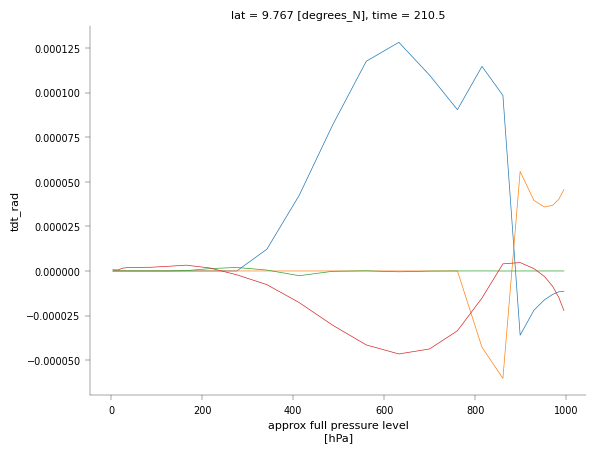

In [259]:
ds_all[0][0].isel(time=210).dt_tg_convection.plot()
ds_all[0][0].isel(time=210).dt_tg_diffusion.plot()
ds_all[0][0].isel(time=210).dt_tg_condensation.plot()
ds_all[0][0].isel(time=210).tdt_rad.plot()

In [327]:
ds[0][0].sel(time=slice(use_time_start, np.inf)).dims['time'] * ds[0][0].sel(time=slice(use_time_start, np.inf)).dims['lon']

138240

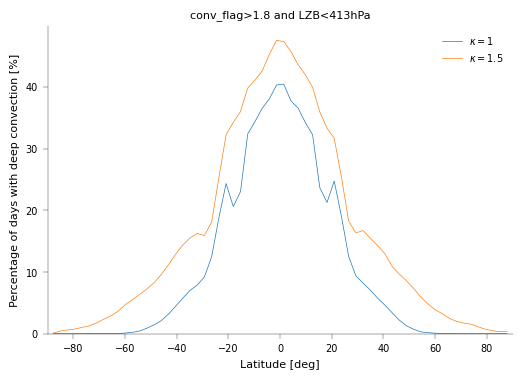

In [365]:
n_time_lon = ds[0][0].sel(time=slice(use_time_start, np.inf)).dims['time'] * ds[0][0].sel(time=slice(use_time_start, np.inf)).dims['lon']
lzb_thresh = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
convflag_thresh = 1.8       # Need more than this to be considered deep convection
fig, ax = plt.subplots(1, n_exp, figsize=(6*n_exp, 4), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    for j in range(n_kappa):
        ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf))
        ax[i].plot(ds_use.lat, 100*(ds_use.where(ds_use.klzbs<lzb_thresh).convflag>convflag_thresh).sum(dim=['lon', 'time'])/n_time_lon, 
                   label=f"$\kappa = {tau_lw[j]}$")
    ax[i].legend()
    ax[i].set_xlabel('Latitude [deg]')
    ax[i].set_ylabel('Percentage of days with deep convection [%]')
    ax[i].set_xlim(-90, 90)
    ax[i].set_ylim(0, ax[i].get_ylim()[1])
    ax[i].set_title(f"conv_flag>{convflag_thresh} and LZB<{int(lzb(lzb_thresh))}hPa")